In [1]:
import numpy as np
import pandas as pd
from numpy.random import normal, multivariate_normal

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [2]:
DATA_DIRECTORY = "C:\\Users\\WDAmo\\GitHub\\font_analysis\\data"
PARAM_LABELS = ["unit", "pen", "cap", "bar", "asc", "desc", "xht", "horz",
                "vert", "cont", "supr", "slnt", "aprt", "crnr", "over", "tapr"]

In [3]:
def extract_data(lin, chain):
    raw_file = pd.read_csv(DATA_DIRECTORY + "\\" + str(lin) + "\\" + str(chain) + ".csv")["chosen.values"]
    df = pd.DataFrame([x[1:-1].split(',') for x in raw_file])
    return df
def extract_all():
    out = []
    for i in range(4): ##For each lineage,
        lin = []
        for j in range(4): ##And each chain inside that lineage
            lin.append(extract_data(i,j))
        out.append(lin)
    return out;
def split_df(df):
    if len(df) % 2 != 0:  # Handling `df` with `odd` number of rows
        df = df.iloc[:-1, :]
    df1, df2 =  np.array_split(df, 2)
    return df1, df2
def split_all(dfs): # Returns the second half of each dataframe, cast correctly
    out = []
    for i in range(4): ##For each lineage,
        lin = []
        for j in range(4): ##And each chain inside that lineage
            upper, lower = split_df(dfs[i][j])
            lin.append(lower.astype('float64').to_numpy())
        out.append(lin)
    return out;
def combine_all(chains):
    full_chain = np.empty((0,16), 'float64')
    for i in range(4):
        for j in range(4):
            full_chain = np.concatenate((full_chain, chains[i][j]))
    return full_chain
def combine_by_font(chains):
    arial = np.empty((0,16), 'float64')
    georgia = np.empty((0,16), 'float64')
    for i in range(4):
        if(i%2==1):
            for j in range(4):
                arial = np.concatenate((arial, chains[i][j]))
        else:            
            for j in range(4):
                georgia = np.concatenate((georgia, chains[i][j]))
    return arial, georgia
def add_noise(dfs, sigma):
    out = []
    noise = np.random.normal(0, sigma, dfs.shape)  
    return (dfs + noise)

In [4]:
raw_data = split_all(extract_all())
dataset = add_noise(combine_all(raw_data),1)

In [5]:
dataset.shape

(34910, 16)

In [6]:
# Checking average length of each split lineage
for i in range(4):
    sum = 0
    for j in range(4):
        l, p = dfs_split[i][j].shape
        sum+= l
    print(str(sum/4))
            

NameError: name 'dfs_split' is not defined

In [ ]:

def add_noise_split(dfs, sigma):
    out = []
    for i in range(4):
        lin = []
        for j in range(4):
            lin.append(add_noise(dfs[i][j], sigma))
        out.append(lin)
    return out
            
noisy_1 = add_noise(dataset, 1)
noisy_10 = add_noise(dataset, 10)
noisy_5 = add_noise(dataset, 5)
noisy_1_split = add_noise_split(raw_data, 1)
noisy_5_split = add_noise_split(raw_data, 5)
noisy_10_split = add_noise_split(raw_data, 10)


In [12]:
X = dataset
n_components_range = np.arange(1,21)
bics = []
for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components, n_init = 5,
                                  covariance_type='spherical')
    gmm.fit(X)
    bics.append(gmm.bic(X))
    print(str(n_components) + ": "+ str(gmm.bic(X)))



1: 5294116.137495516
2: 5286583.807191101
3: 5278350.360470182
4: 5271454.564613434
5: 5265815.226833031
6: 5258539.536125149
7: 5255985.515420604
8: 5251356.567920986
9: 5247602.112381491
10: 5241640.652576938
11: 5242729.268282883
12: 5230514.9882215
13: 5220637.324580504
14: 5220112.267845931
15: 5209330.30686948
16: 5207843.314213449
17: 5205667.043168138
18: 5204067.271378351
19: 5193486.881926966
20: 5194016.725634426


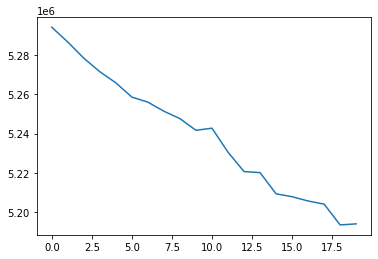

In [13]:
plt.plot(bics)

In [15]:
#Running the GMM on the whole dataset
results = []
n_comps = 12
gmm = mixture.GaussianMixture(n_components=n_comps,
                              covariance_type='full', max_iter=5000, n_init=5)
gmm.fit(dataset)
weights = gmm.weights_
means = gmm.means_
chainframe = pd.DataFrame({'weight': weights, 'mean': list(means)}, columns=['weight', 'mean']).sort_values('weight', ascending=False)

chainframe
            
            

,weight,mean
10,0.263007,"[51.899145227773964, 59.204272681402124, 47.49..."
7,0.093910,"[59.518855951701916, 47.56208637713423, 48.133..."
2,0.084666,"[62.90029960767179, 65.74747149814384, 68.4734..."
9,0.082965,"[35.79502105798364, 76.16006198383985, 34.6478..."
4,0.079147,"[39.902318459627224, 74.77350892713498, 69.361..."
5,0.076731,"[31.98158688202226, 47.90854945665272, 47.1390..."
0,0.067627,"[26.618082415152376, 35.58410504184095, 27.996..."
1,0.056688,"[47.092284580558605, 54.14729111588379, 67.149..."
8,0.053575,"[24.393896182845666, 29.98794751869404, 35.357..."
6,0.053030,"[42.82279351386059, 83.63775819484736, 25.6777..."


In [16]:
chainframe = chainframe.to_numpy()

In [18]:
top_6_means= chainframe[:6,1]
top_6_weights = chainframe[:6,0]
rounded_6 = []
for i in top_6_means:
    rounded_6.append(np.round(i))
rounded_6

[array([52., 59., 47., 44., 55., 58., 51., 51., 40., 35., 45., 52., 37.,
        39., 40., 53.]),
 array([60., 48., 48., 50., 54., 62., 79., 47., 59., 70., 33., 53., 54.,
        62., 59., 52.]),
 array([63., 66., 68., 59., 56., 43., 43., 75., 58., 28., 63., 75., 70.,
        37., 63., 33.]),
 array([36., 76., 35., 42., 28., 51., 39., 45., 31., 48., 41., 50., 73.,
        67., 32., 66.]),
 array([40., 75., 69., 31., 37., 46., 45., 25., 67., 47., 42., 57., 30.,
        39., 58., 35.]),
 array([32., 48., 47., 68., 62., 19., 49., 35., 55., 59., 31., 50., 45.,
        61., 45., 65.])]

In [19]:
top_6_weights

array([0.2630069515352187, 0.09391034852447379, 0.08466609000794229,
       0.0829649133618369, 0.07914677787906303, 0.07673102520803197],
      dtype=object)

In [18]:
list(rounded_6[0])

[52.0,
 48.0,
 47.0,
 55.0,
 53.0,
 50.0,
 59.0,
 45.0,
 51.0,
 63.0,
 42.0,
 55.0,
 41.0,
 55.0,
 51.0,
 49.0]

In [20]:
def load_font(arr, filename):#List of values -> URL
    rounded = np.around(arr)
    out = "localhost:1999/font/"+filename+"/"
    for i in arr:
        out+= str(i)[:2] + "-"
    return out[:-1]+"/"

for i in range(1,7):
    print(load_font(rounded_6[i-1], "gmm"+str(i)))
    


localhost:1999/font/gmm1/52-59-47-44-55-58-51-51-40-35-45-52-37-39-40-53/
localhost:1999/font/gmm2/60-48-48-50-54-62-79-47-59-70-33-53-54-62-59-52/
localhost:1999/font/gmm3/63-66-68-59-56-43-43-75-58-28-63-75-70-37-63-33/
localhost:1999/font/gmm4/36-76-35-42-28-51-39-45-31-48-41-50-73-67-32-66/
localhost:1999/font/gmm5/40-75-69-31-37-46-45-25-67-47-42-57-30-39-58-35/
localhost:1999/font/gmm6/32-48-47-68-62-19-49-35-55-59-31-50-45-61-45-65/
